In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
P0 = 100000. # Pressure, Pa
T0 = 279.    # Temperature, K
S0 = -0.01   # Supersaturation, 1-RH
aer =  pm.AerosolSpecies('ammonium sulfate',
                          pm.Lognorm(mu=0.05, sigma=2.0, N=1000.),
                          kappa=0.7, bins=20)
accom = 0.1
V = 1.0
aer.r_drys
model = pm.ParcelModel([aer,], V, T0, S0, P0, accom=accom)

In [5]:
from functools import partial
import jax.numpy as jnp
from jax import jit

from pyrcel._parcel_aux_numba import parcel_ode_sys as rhs

rhs_part = partial(rhs, t=0, nr=model._nr, r_drys=model._r_drys,
                   Nis = model._Nis, V=1.0, kappas=model._kappas, accom=accom)
x1 = rhs_part(model.y0.astype(np.float64))
x1

DeviceArray([ 1.0000000e+00, -1.2179569e+01, -9.7709168e-03,
              1.0293072e-13, -1.0293072e-13,  0.0000000e+00,
              4.8924255e-04, -8.6569917e-13, -8.6367756e-13,
             -8.6060954e-13, -8.5599876e-13, -6.2839066e-12,
             -8.3929126e-13, -6.1074470e-12, -8.0617913e-13,
             -7.8071235e-13, -7.4793015e-13, -5.2327955e-12,
             -6.5814867e-13,  3.2483155e-12, -5.3876380e-13,
              2.5495012e-12, -2.9935459e-12, -3.3899665e-13,
             -2.7816660e-13, -1.6571224e-12,  9.5737600e-13],            dtype=float32)

In [6]:
jrhs = jit(rhs)
jrhs_part = partial(jrhs, t=0, nr=jnp.asarray(model._nr), r_drys=jnp.asarray(model._r_drys),
                    Nis=jnp.asarray(model._Nis), V=1.0, kappas=jnp.asarray(model._kappas), accom=accom)

In [8]:
x2 = jrhs_part(model.y0)
x2

DeviceArray([ 1.0000000e+00, -1.2179569e+01, -9.7709158e-03,
             -5.1125673e-13,  5.1125673e-13,  0.0000000e+00,
              4.8924232e-04,  1.5063164e-11, -7.7730964e-13,
              5.5078997e-12,  0.0000000e+00,  5.9442338e-13,
             -5.4553926e-12, -5.9423807e-12,  7.0943763e-12,
              2.1859942e-12, -5.7590612e-12,  1.2728422e-12,
             -4.6070407e-13,  3.3686231e-12,  9.6977472e-13,
              2.1717972e-12, -4.5712253e-12,  2.6780733e-12,
             -1.1682995e-12, -3.3590307e-12,  1.5601680e-12],            dtype=float32)

In [9]:
100*np.abs(x1 - x2) / x1

DeviceArray([ 0.00000000e+00, -0.00000000e+00, -9.53157814e-06,
              5.96699829e+02, -5.96699829e+02,             nan,
              4.75900233e-05, -1.83999988e+03, -1.00000200e+01,
             -7.39999817e+02, -1.00000000e+02, -1.09459457e+02,
             -5.49999939e+02, -2.70270562e+00, -9.80000000e+02,
             -3.79999969e+02, -6.69999939e+02, -1.24324326e+02,
             -3.00000000e+01,  3.70369291e+00, -2.80000000e+02,
              1.48148174e+01, -5.27026939e+01, -8.89999939e+02,
             -3.19999939e+02, -1.02702637e+02,  6.29629288e+01],            dtype=float32)

In [24]:
from jax import jacfwd, jacrev
import jax.numpy as jnp

jrhs_jac = jacfwd(rhs_part, argnums=0, )
jj = jrhs_jac(jnp.asarray(model.y0))
jj.shape

(27, 27)

In [21]:
def func(y, t):
    return jrhs_part(jnp.asarray(y))
def Dfun(y, t):
    return jrhs_jac(jnp.asarray(y))

In [22]:
from scipy.integrate import odeint

t_end = 20.
dt = 0.01
ts = np.arange(0, t_end, dt)

out = odeint(func, model.y0, ts, Dfun=Dfun)

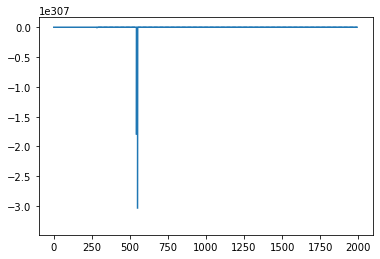

In [23]:
plt.plot(out[:, 6])

In [28]:
from scipy.integrate import solve_ivp

def func(t, y):
    return jrhs_part(jnp.asarray(y))
def Dfun(t, y):
    return jrhs_jac(jnp.asarray(y))

t_end = 20.
dt = 0.01
ts = np.arange(0, t_end, dt)

sol = solve_ivp(func, (0, t_end), model.y0, method='BDF', t_eval=ts, max_step=dt, jac=Dfun)

ValueError: array must not contain infs or NaNs

In [49]:
def func(t, u):
    sigma, rho, beta = 10., 28., 8./3.
    x, y, z = u
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

j = jacfwd(func, argnums=1)

def Dfun(t, u):
    return jnp.asarray(j(t, u))
    
fun(0, [0., 1., 1.])
Dfun(0, [0., 1., 1.])


t_end = 40.
dt = 0.01
ts = np.arange(0, t_end, dt)

sol = solve_ivp(func, (0, t_end), jnp.asarray([1., 1., 1.]), method='BDF', t_eval=ts,  jac=Dfun)
sol    

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 4540
     njev: 52
      nlu: 309
      sol: None
   status: 0
  success: True
        t: array([0.000e+00, 1.000e-02, 2.000e-02, ..., 3.997e+01, 3.998e+01,
       3.999e+01])
 t_events: None
        y: array([[ 1.        ,  1.01397016,  1.05033552, ..., 14.81372907,
        14.31751256, 13.6993453 ],
       [ 1.        ,  1.26055145,  1.52571907, ..., 10.51995459,
         8.72468737,  6.98802925],
       [ 1.        ,  0.98512033,  0.97346428, ..., 39.40787774,
        39.7546783 , 39.79096885]])
 y_events: None

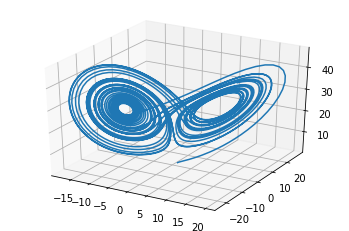

In [50]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

out = sol.y
ax.plot(out[0], out[1], out[2])